# [Ghouls, Goblins, and Ghosts... Boo!](https://www.kaggle.com/c/ghouls-goblins-and-ghosts-boo/rules)

This is a fun Halloween competition. We have some characteristics of monsters and the goal is to predict the type of monsters: ghouls, goblins or ghosts.

At first I do data exploration to get some insights. Then I try various models for prediction. The final prediction is done with the help of ensemble and majority voting.

In [1]:
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
import warnings
warnings.filterwarnings('ignore')

### <a id="datex">Data exploration</a>

In [3]:
train = pd.read_csv(r"D:\kaggle\ghouls goblins ghosts\train.csv")
test = pd.read_csv(r"D:\kaggle\ghouls goblins ghosts\test.csv")

In [4]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
id               371 non-null int64
bone_length      371 non-null float64
rotting_flesh    371 non-null float64
hair_length      371 non-null float64
has_soul         371 non-null float64
color            371 non-null object
type             371 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 20.4+ KB


So there are 4 numerical variables and 1 categorical. And no missing values, which is nice!

In [6]:
train.describe(include='all')

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
count,371.000000,371.000000,371.000000,371.000000,371.000000,371,371
unique,NaN,NaN,NaN,NaN,NaN,6,3
top,NaN,NaN,NaN,NaN,NaN,white,Ghoul
freq,NaN,NaN,NaN,NaN,NaN,137,129
mean,443.676550,0.434160,0.506848,0.529114,0.471392,NaN,NaN
std,263.222489,0.132833,0.146358,0.169902,0.176129,NaN,NaN
min,0.000000,0.061032,0.095687,0.134600,0.009402,NaN,NaN
25%,205.500000,0.340006,0.414812,0.407428,0.348002,NaN,NaN
50%,458.000000,0.434891,0.501552,0.538642,0.466372,NaN,NaN
75%,678.500000,0.517223,0.603977,0.647244,0.600610,NaN,NaN


Numerical columns are either normalized or show a percentage, so no need to scale them.

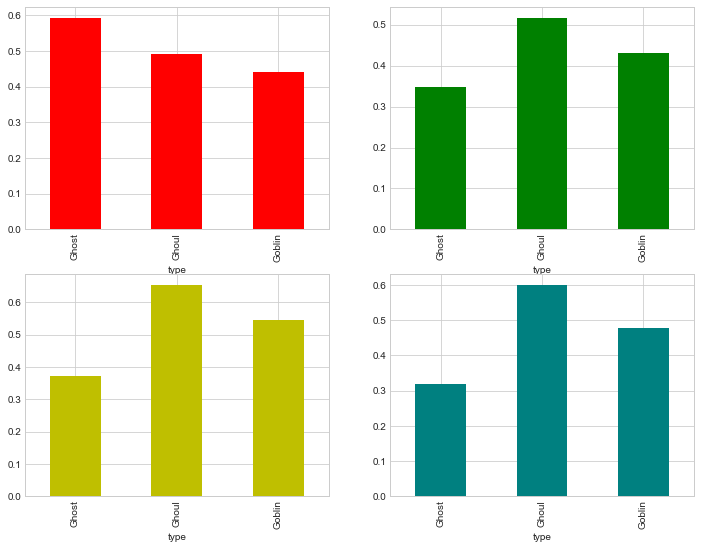

In [7]:
plt.subplot(2,2,1)
train.groupby('type').mean()['rotting_flesh'].plot(kind='bar',figsize=(12,9), color='r')
plt.subplot(2,2,2)
train.groupby('type').mean()['bone_length'].plot(kind='bar',figsize=(12,9), color='g')
plt.subplot(2,2,3)
train.groupby('type').mean()['hair_length'].plot(kind='bar',figsize=(12,9), color='y')
plt.subplot(2,2,4)
train.groupby('type').mean()['has_soul'].plot(kind='bar',figsize=(12,9), color='teal')

It seems that all numerical features may be useful.

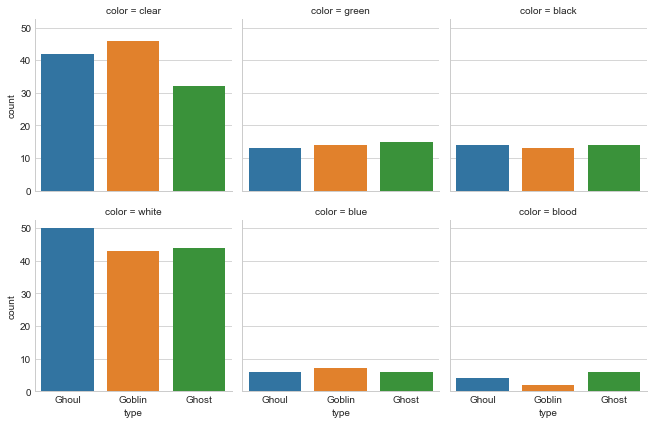

In [8]:
sns.factorplot("type", col="color", col_wrap=3, data=train, kind="count", size=3)

Funny, but many colors are evenly distributes among the monsters. So they maybe nor very useful for analysis.

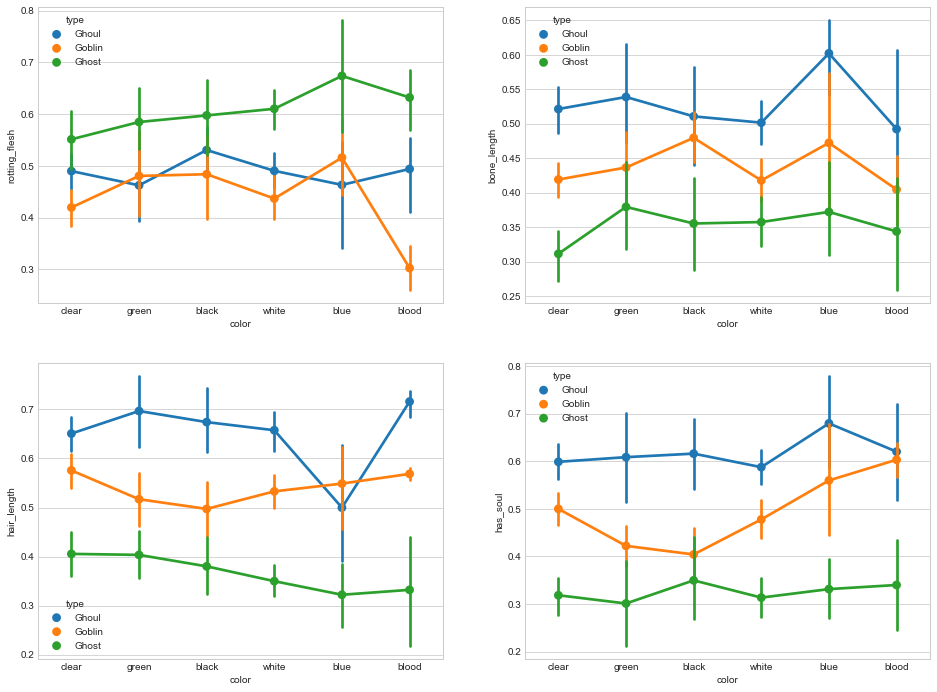

In [9]:
fig, ax = plt.subplots(2, 2, figsize = (16, 12))
sns.pointplot(x="color", y="rotting_flesh", hue="type", data=train, ax = ax[0, 0])
sns.pointplot(x="color", y="bone_length", hue="type", data=train, ax = ax[0, 1])
sns.pointplot(x="color", y="hair_length", hue="type", data=train, ax = ax[1, 0])
sns.pointplot(x="color", y="has_soul", hue="type", data=train, ax = ax[1, 1])

In most cases color won't "help" other variables to improve accuracy.

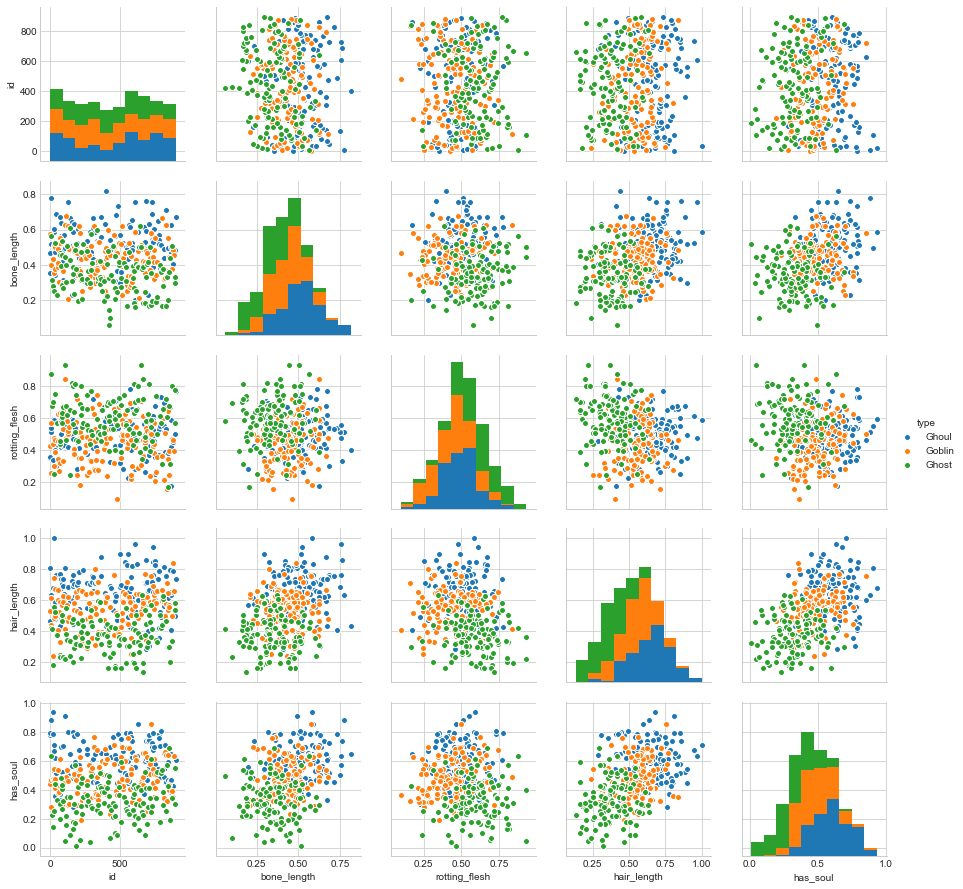

In [10]:
sns.pairplot(train, hue='type')

This pairplot shows that data is distributed normally. And while most pairs are widely scattered (in relationship to the type), some of them show clusters: hair_length and has_soul, hair_length and bone_length. I decided to create new variables with multiplication of these columns and it worked great!

### <a id="datapre">Data prepration</a>

In [11]:
train['hair_soul'] = train['hair_length'] * train['has_soul']
train['hair_bone'] = train['hair_length'] * train['bone_length']
test['hair_soul'] = test['hair_length'] * test['has_soul']
test['hair_bone'] = test['hair_length'] * test['bone_length']
train['hair_soul_bone'] = train['hair_length'] * train['has_soul'] * train['bone_length']
test['hair_soul_bone'] = test['hair_length'] * test['has_soul'] * test['bone_length']

In [12]:
#test_id will be used later, so save it
test_id = test['id']
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

In [13]:
train.head()

,bone_length,rotting_flesh,hair_length,has_soul,color,type,hair_soul,hair_bone,hair_soul_bone
0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul,0.363825,0.165118,0.128980
1,0.575560,0.425868,0.531401,0.439899,green,Goblin,0.233763,0.305853,0.134545
2,0.467875,0.354330,0.811616,0.791225,black,Ghoul,0.642171,0.379735,0.300456
3,0.776652,0.508723,0.636766,0.884464,black,Ghoul,0.563196,0.494546,0.437408
4,0.566117,0.875862,0.418594,0.636438,green,Ghost,0.266409,0.236973,0.150818


In [14]:
col = 'color'
train=pd.get_dummies(train,prefix_sep='_',prefix=col,columns=[col])
test=pd.get_dummies(test,prefix_sep='_',prefix=col,columns=[col])

In [15]:
X_train = train.drop('type', axis=1)
le = LabelEncoder()
Y_train = le.fit_transform(train.type.values)
X_test = test

### <a id="featuresel">Feature Selection</a>

In [16]:
clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X_train, Y_train)

In [17]:
clf.feature_importances_

array([0.0825616 , 0.11287719, 0.12858705, 0.11587339, 0.17303023,
       0.14526538, 0.20064012, 0.0069873 , 0.00195819, 0.00627869,
       0.0095414 , 0.00678309, 0.00961637])

In [18]:
features_df=pd.DataFrame({'features':X_train.columns.values,'weights':clf.feature_importances_}).\
sort_values('weights',ascending=False)
features_df

,features,weights
6,hair_soul_bone,0.200640
4,hair_soul,0.173030
5,hair_bone,0.145265
2,hair_length,0.128587
3,has_soul,0.115873
1,rotting_flesh,0.112877
0,bone_length,0.082562
12,color_white,0.009616
10,color_clear,0.009541
7,color_black,0.006987


Graphs and model show that color has little impact, so I won't use it. In fact I tried using it, but the result got worse. And three features, which I created, seem to be important!

In [19]:
np.log2(7)

2.807354922057604

In [20]:
best_features=features_df[features_df.weights>0.01].features.values.tolist()
X_train=X_train[best_features]
X_test=X_test[best_features]

In [21]:
X, Xcv, y, ycv = train_test_split(X_train, Y_train, test_size=0.20, random_state=36)

### <a id="model">Model</a>

##### <a id="rfc">Random Forest Classifier</a>

In [22]:
forest = RandomForestClassifier()

parameter_grid = {'n_estimators' : [10, 20, 150],
                  'criterion' : ['gini', 'entropy'],
                  'max_features' : ['auto', 'sqrt', 'log2'],
                  'max_depth' : [None, 5, 100],
                  'min_samples_split' : [2, 5, 7],
                  'min_weight_fraction_leaf' : [0.0, 0.1],
                  'max_leaf_nodes' : [40, 80],
                 }

grid_search = GridSearchCV(forest, param_grid=parameter_grid, scoring='accuracy', cv=StratifiedKFold(5))
grid_search.fit(X_train, Y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.738544474393531
Best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'max_leaf_nodes': 80, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.1, 'n_estimators': 10}


In [23]:
#Optimal parameters
clf = RandomForestClassifier(n_estimators=10, n_jobs=-1, criterion = 'gini', max_features = 'auto',
                             min_samples_split=7, min_weight_fraction_leaf=0.0,
                             max_leaf_nodes=40, max_depth=100)

calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv=5)
calibrated_clf.fit(X,y)
ycv_pred = calibrated_clf.predict_proba(Xcv)

In [24]:
print("Validation accuracy: ", 
      sum(pd.DataFrame(ycv_pred, columns=le.classes_).idxmax(axis=1).values == le.inverse_transform(ycv))/len(ycv))

Validation accuracy:  0.7066666666666667


Usually RandomForest requires a lot of data for good performance. It seems that in this case there was too little data for it.

##### <a id="logreg">Logistic Regression</a>

In [25]:
logreg = LogisticRegression()

parameter_grid = {'solver' : ['newton-cg', 'lbfgs'],
                  'multi_class' : ['ovr', 'multinomial'],
                  'C' : [0.005, 0.01, 1, 10, 100, 1000],
                  'tol': [0.0001, 0.001, 0.005]
                 }

grid_search = GridSearchCV(logreg, param_grid=parameter_grid, cv=StratifiedKFold(5))
grid_search.fit(X_train, Y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7493261455525606
Best parameters: {'C': 1, 'multi_class': 'multinomial', 'solver': 'newton-cg', 'tol': 0.0001}


In [26]:
log_reg = LogisticRegression(C = 1, tol = 0.0001, solver='newton-cg', multi_class='multinomial')
log_reg.fit(X,y)
ycv_pred_lr = log_reg.predict_proba(Xcv)

In [27]:
print("Validation accuracy: ", 
      sum(pd.DataFrame(ycv_pred_lr, columns=le.classes_).idxmax(axis=1).values == le.inverse_transform(ycv))/len(ycv))

Validation accuracy:  0.7733333333333333


Approximately 8% improvement in the accuracy.

##### <a id="svm">Support Vector Machine</a>

In [28]:
svc_m=svm.SVC()

parameter_grid = {'kernel' : ['linear', 'rbf'],
                  'C' : [0.005, 0.01, 1, 10, 100, 1000],
                  'tol': [0.0001, 0.001, 0.005]
                 }

grid_search = GridSearchCV(svc_m, param_grid=parameter_grid, cv=StratifiedKFold(5))
grid_search.fit(X_train, Y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7547169811320755
Best parameters: {'C': 100, 'kernel': 'rbf', 'tol': 0.0001}


In [29]:
svm_model = svm.SVC(C = 100, tol = 0.0001, kernel='rbf')
svm_model.fit(X,y)
ycv_pred_svm = svm_model.predict(Xcv)

In [30]:
print("Validation accuracy: ", 
      sum(le.inverse_transform(ycv_pred_svm) == le.inverse_transform(ycv))/len(ycv))

Validation accuracy:  0.7333333333333333


It seems that regression is better. The reason? As far as I understand, the algorithms are similar, but with different loss function. And most importantly: SVC is a hard classifier while LR gives probabilities.

##### <a id="vc">Voting Classifier</a>

As far as I can understand, while using hard voting, it is better to used unfitted estimators. Hard voting uses predicted class labels for majority rule voting. Soft voting predicts the class label based on the argmax of the sums of the predicted probalities, which is recommended for an ensemble of well-calibrated classifiers.

In [31]:
vc_soft=VotingClassifier([('LR', log_reg), ('CRF', calibrated_clf),('GNB', GaussianNB())],voting='soft')

In [32]:
vc_hard=VotingClassifier([('LR', LogisticRegression()), 
                          ('CRF', CalibratedClassifierCV(RandomForestClassifier())),('GNB', GaussianNB())],voting='hard')

In [33]:
ycv_hard_predict = le.inverse_transform(vc_hard.fit(X, y).predict(Xcv))
ycv_soft_predict = le.inverse_transform(vc_soft.fit(X, y).predict(Xcv))

In [34]:
print("Validation accuracy (hard): ", 
      sum(ycv_hard_predict == le.inverse_transform(ycv))/len(ycv))

Validation accuracy (hard):  0.68


In [35]:
print("Validation accuracy (soft): ", 
      sum(ycv_soft_predict == le.inverse_transform(ycv))/len(ycv))

Validation accuracy (soft):  0.76


### <a op="model">Output</a>

In [36]:
op_logistic_reg=pd.DataFrame(log_reg.predict_proba(X_test), columns=le.classes_).idxmax(axis=1).values
op_voting_soft=le.inverse_transform(vc_soft.fit(X, y).predict(X_test))
op_voting_hard=le.inverse_transform(vc_hard.fit(X, y).predict(X_test))

In [37]:
submission = pd.DataFrame({'id':test_id, 'type':op_voting_soft})
submission.to_csv(r"D:\kaggle\ghouls goblins ghosts\op_voting_soft.csv", index=False)

submission = pd.DataFrame({'id':test_id, 'type':op_logistic_reg})
submission.to_csv(r"D:\kaggle\ghouls goblins ghosts\op_logistic_reg.csv", index=False)

submission = pd.DataFrame({'id':test_id, 'type':op_voting_hard})
submission.to_csv(r"D:\kaggle\ghouls goblins ghosts\op_voting_hard.csv", index=False)

Accuracy:<br>
- soft voting:  0.73913<br>
 hard voting:  0.73345<br>
 logistic reg: 0.73534<br>